# JupyLabBook @ SIRIUS

In [1]:
__version__ = '2.0'
print("JupyLabBook version: %s"%__version__)
print("More info on: %s"%"https://github.com/ArnaudHemmerle/JupyLabBook")

# import custom libraries
import lib.frontend as FE
from lib.extraction.common import PyNexus as PN
from lib.extraction import GIXD as GIXD
from lib.extraction import GIXS as GIXS
from lib.extraction import PilatusSum as PilatusSum


#import useful libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats, Javascript, display

# necessary for plotting in the notebook
%matplotlib inline

# to avoid having a large notebook
set_matplotlib_formats('png', 'pdf')
    
# to have all the cells expanded (not collapsed)
display(Javascript('IPython.OutputArea.prototype._should_scroll = function(lines) {return false;}'))
        
# define the class experiment
class Experiment:
    """
    Class Experiment is used to pass arguments concerning the current experiment only.
    """
    def __init__(self):
        pass

# test if the expt already exists (avoid loosing info when reloading this cell)
try:
    expt.notebook_name
except:
    expt = Experiment() 

# necessary for saving in pdf
expt.notebook_name = 'JupyLabBook.ipynb'

# directory where the data will be saved
expt.working_dir = "working/"

# directory where the nexus files are 
expt.recording_dir = "recording/"

# directory where the logs are
expt.logs_dir = "logs/"   

FE.action.Check_and_init(expt)

JupyLabBook version: 2.0
More info on: https://github.com/ArnaudHemmerle/JupyLabBook


<IPython.core.display.Javascript object>

Data reduction will be saved in the folder:
working/

The original nexus files should be in the folder:
recording/

The log files should be in the folder:
logs/



<IPython.core.display.Javascript object>

CF.Extract_GIXS(nxs_filename='SIRIUS_2019_11_07_00325.nxs',working_dir=expt.working_dir, recording_dir=expt.recording_dir,logz=True,wavelength=0.1208,thetai=0.0,distance=435.5,pixel_PONI_x=565.5,pixel_PONI_y=996.5,pixel_size=0.172,qxymin=0.0,qxymax=18.0,qzmin=0.0,qzmax=19.0,show_data_stamps=False,force_gamma_delta=False,fgamma=0.0,fdelta=11.578,verbose=False,absorbers='29 - Vide',cmap='viridis')

### SIRIUS_2019_11_07_00325: tscan 10 10

 - Open Nexus Data File :
	recording/SIRIUS_2019_11_07_00325.nxs
	. Number of data points:  11
	. Available Counters:
		 0  ------->  hu36energy
		 1  ------->  current
		 2  ------->  mon2
		 3  ------->  mon4
		 4  ------->  camxdirect
		 5  ------->  pilatus
		 6  ------->  pilatusroi1
		 7  ------->  integration_time
		 8  ------->  sensorsRelTimestamps
		 9  ------->  sensorsTimestamps
	. Pilatus data found, (column 5, alias pilatus)
	. For more details on the geometry, see:                                         
	 	 -Fig.2 in doi:10.1107/S0909049512022017
	 	 -Slide 4 in http://gisaxs.com/files/Strzalka.pdf
	. Absorbers: 29 - Vide
 	. Gamma is forced to the value : gamma = 0 
 	. Delta is forced to the value : delta = 11.578 


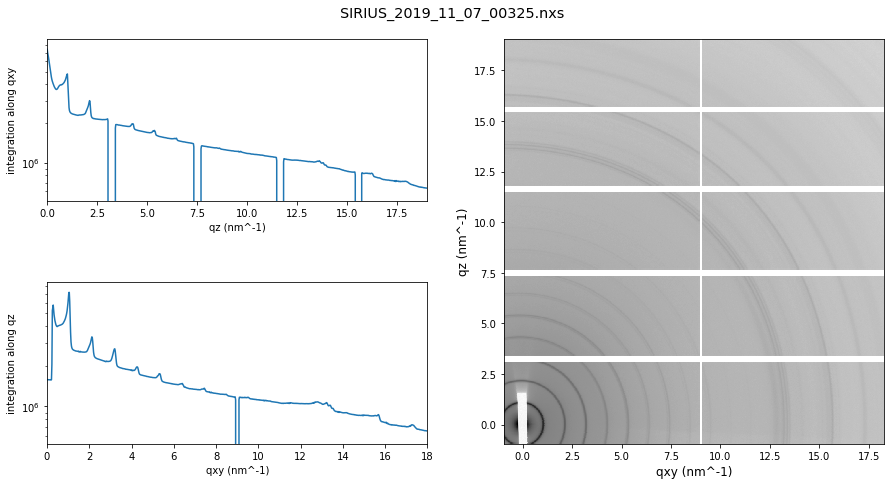

	. Integrated qz vs qxy:
	 working/SIRIUS_2019_11_07_00325_integrated_qz.dat
 
	. Integrated qxy vs qz:
	 working/SIRIUS_2019_11_07_00325_integrated_qxy.dat
 
	. Original matrix saved in:
	 working/SIRIUS_2019_11_07_00325.mat
 
	. Tiff saved in:
	 working/SIRIUS_2019_11_07_00325.tiff
 


In [4]:
images_sum, integrated_qxy, integrated_qz, qxy_array, qz_array=\
GIXS.Treat(nxs_filename='SIRIUS_2019_11_07_00325.nxs',recording_dir=expt.recording_dir,wavelength=0.1208,thetai=0.0,distance=435.5,pixel_PONI_x=565.5,pixel_PONI_y=996.5,pixel_size=0.172,force_gamma_delta=False,fgamma=0.0,fdelta=11.578,qxymin=0.0,qxymax=18.0,qzmin=0.0,qzmax=19.0,absorbers='29 - Vide',logz=True,cmap='Greys',working_dir=expt.working_dir,show_data_stamps=True,plot=True, save=True, verbose=True)

In [5]:
FE.action.Choose(expt)

interactive(children=(SelectMultiple(description='nxs_files', options=('SIRIUS_Isotherm_2019_02_17_01544.nxs',…